In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

# Load in chat data.

In [2]:
from datasets import load_dataset

# Load the lmsys/chatbot_arena_conversations dataset from HuggingFace
chat_data = load_dataset("lmarena-ai/arena-human-preference-55k", split="train")

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# HuggingFace datasets.Dataset doesn't have .head(), so use .select or .to_pandas()
# Show first 5 rows as a DataFrame
chat_data_df = chat_data.to_pandas()
chat_data_df.shape

(57477, 9)

In [4]:
chat_data_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [5]:
# Only keep games where one of the specified models is the winner
target_models = [
    "gpt-4-0125-preview",
    "gpt-4-1106-preview",
    "gpt-4-0314",
    "gpt-4-0613",
    "qwen1.5-73b-chat"
]

# Assuming chat_data_df has a 'winner' column with model names
strong_winners = chat_data_df[
    ((chat_data_df["winner_model_a"] == 1) & (chat_data_df["model_a"].isin(target_models))) |
    ((chat_data_df["winner_model_b"] == 1) & (chat_data_df["model_b"].isin(target_models))) |
    ((chat_data_df["winner_tie"] == 1) & (chat_data_df["model_a"].isin(target_models)) | (chat_data_df["model_b"].isin(target_models)))
]

In [6]:
# all conversations where the winner is one of the top 5 models. this should, in hopes, provide a good
# signal for what a "good" answer is.
strong_winners.shape # 15242

(15242, 9)

# Visualize Distribution of Rouge Scores For Nonchosen Answer.

In [7]:
# !pip install rouge_score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rouge_similarity(hypotheis, reference):
    return scorer.score(hypotheis, reference)["rougeL"].fmeasure

In [8]:
# Example usage
hyp = "the cat sat on the mat"
ref = "the cat is sitting on the mat"

print(rouge_similarity(hyp, ref))

0.7692307692307692


In [9]:
chat_data_df_first_100 = chat_data_df.head(100)

In [10]:
import pandas as pd
from rouge_score import rouge_scorer

# Example: assuming your DataFrame is called df with columns response_a, response_b
# df = pd.read_csv("your_file.csv")

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def compute_rouge(row):
    scores = scorer.score(row["response_a"], row["response_b"])
    return pd.Series({
        "rougeL_f": scores["rougeL"].fmeasure
    })

# Apply across rows
chat_data_df_first_100[["rougeL_f"]] = chat_data_df_first_100.apply(compute_rouge, axis=1)

chat_data_df_first_100.head()

/tmp/ipykernel_2300441/922331732.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chat_data_df_first_100[["rougeL_f"]] = chat_data_df_first_100.apply(compute_rouge, axis=1)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,rougeL_f
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0.172600
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,0.284229
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,0.332604
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0.240385
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,0.300268


Distribution of rouge scores between preferred vs. unpreferred response.

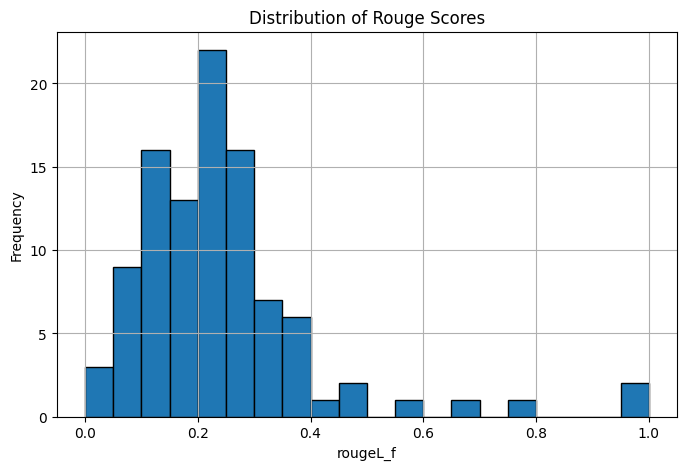

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
chat_data_df_first_100["rougeL_f"].hist(bins=20, edgecolor='black')
plt.title("Distribution of Rouge Scores")
plt.xlabel("rougeL_f")
plt.ylabel("Frequency")
plt.show()


# Score Answers with Reward Model.

In [14]:
from transformers import AutoTokenizer, pipeline
import torch

# Reward model
model_name = "NCSOFT/Llama-3-OffsetBias-RM-8B"

# Load tokenizer and pipeline once
tokenizer = AutoTokenizer.from_pretrained(model_name)
rm_pipeline = pipeline( # this step is slow.
    "sentiment-analysis",
    model=model_name,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    model_kwargs={"torch_dtype": torch.bfloat16},
    return_all_scores=True,
    function_to_apply="none"
)

# Example: 1 prompt, 4 responses
prompt = "Explain why the sky appears blue during the day."
responses = [
    "The blue color is due to Rayleigh scattering of sunlight in the atmosphere.",
    "Because the ocean is blue and reflects its color into the sky.",
    "It depends on the weather, sometimes the sky is green.",
    "Air molecules scatter shorter wavelengths of light more strongly than longer ones."
]

# Build batched input (prompt + response)
pairs = [prompt + "\n" + r for r in responses] # a list of (prompt + response) concatenated strings.

# Run batched scoring
outs = rm_pipeline(pairs, batch_size=4, truncation=True, padding=True)

# Inspect results
for r, o in zip(responses, outs):
    scores = {d["label"]: d["score"] for d in o}
    print(f"Response: {r}\nScores: {scores}\n")


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 97.22it/s]
Device set to use cpu
/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Response: The blue color is due to Rayleigh scattering of sunlight in the atmosphere.
Scores: {'LABEL_0': 2.578125}

Response: Because the ocean is blue and reflects its color into the sky.
Scores: {'LABEL_0': -0.263671875}

Response: It depends on the weather, sometimes the sky is green.
Scores: {'LABEL_0': -0.93359375}

Response: Air molecules scatter shorter wavelengths of light more strongly than longer ones.
Scores: {'LABEL_0': 3.53125}



# Load in Chat Datasets.

In [15]:
# load in chat dataset.
def get_dataset(dataset_name: str, split: str):
    dataset = load_dataset(dataset_name, split) # train.
    dataset = dataset.select(range(0, 10))
    return dataset

In [ ]:
chatbot_arena = "lmarena-ai/arena-human-preference-55k"
lmsys = "lmsys/lmsys-chat-1m"
# Load the lmsys/chatbot_arena_conversations dataset from HuggingFace
cba_data = load_dataset(chatbot_arena, split="train")
lmsys_data = load_dataset(lmsys, split="train") 
# Question: convos are multi-turn. how exactly do we score them? we score the final output.

In [17]:
cba_data.select(range(5))  # First 5 examples

Dataset({
    features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
    num_rows: 5
})

In [18]:
# To see a specific example:
print(lmsys_data[0]), print(cba_data[0])

{'conversation_id': '33f01939a744455c869cb234afca47f1', 'model': 'wizardlm-13b', 'conversation': [{'content': 'how can identity protection services help protect me against identity theft', 'role': 'user'}, {'content': "Identity protection services can help protect you against identity theft in several ways:\n\n1. Monitoring: Many identity protection services monitor your credit reports, public records, and other sources for signs of identity theft. If they detect any suspicious activity, they will alert you so you can take action.\n2. Credit freeze: Some identity protection services can help you freeze your credit, which makes it more difficult for thieves to open new accounts in your name.\n3. Identity theft insurance: Some identity protection services offer insurance that can help you recover financially if you become a victim of identity theft.\n4. Assistance: Many identity protection services offer assistance if you become a victim of identity theft. They can help you file a police

(None, None)

Generate Answers. Choose Best Answer. Evaluate the Response.

Run: python best-of-n-chat.py --config bon.yaml


In [ ]:
# question: should we stick to Qwen/Qwen2.5-1.5B-Instruct for chat?

Beam Search

In [ ]:
# recommended process reward model for chat: 
# https://huggingface.co/UW-Madison-Lee-Lab/VersaPRM